# Ensemble phase picking
- Yiyu Ni (niyiyu@uw.edu)
- Last updated: April 20, 2023

### import packages

In [1]:
import obspy
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../ELEP/src/")
# sys.path.append("../../PNSN-catalog/seisbench/")

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

from ensemble_coherence import ensemble_semblance
from ensemble_statistics import ensemble_statistics
from trigger_func import picks_summary_simple
import seisbench.models as sbm
from obspy.core.utcdatetime import UTCDateTime

### Load data
We read mSEED from [PB.B204](https://ds.iris.edu/gmap/#network=PB&station=B204&planet=earth) station, Jan 6, 2023. The stream contains 10-hour 3-component waveform from EH channel (short period high-gain).

We read the number of data points in each trace, delta (reciprocal of sampling rate), and start time of the trace.

In [2]:
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client

client = Client("IRIS")

3 Trace(s) in Stream:
PB.B204..EH1 | 2023-01-06T14:00:00.008400Z - 2023-01-06T23:59:58.998400Z | 100.0 Hz, 3599900 samples
PB.B204..EH2 | 2023-01-06T14:00:00.008400Z - 2023-01-06T23:59:58.998400Z | 100.0 Hz, 3599900 samples
PB.B204..EHZ | 2023-01-06T14:00:00.008400Z - 2023-01-06T23:59:58.998400Z | 100.0 Hz, 3599900 samples


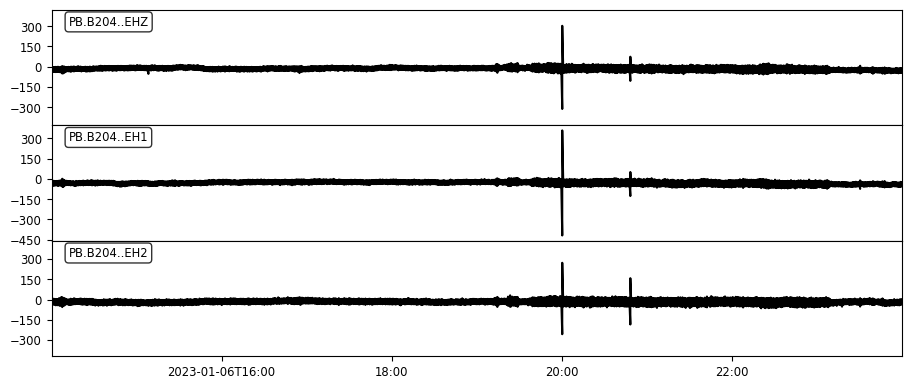

In [8]:
s = client.get_waveforms("PB", "B204", location = "*", channel = "EH?", 
                         starttime = UTCDateTime("2023-01-06T14:00:00.000000"), 
                         endtime   = UTCDateTime("2023-01-06T23:59:59.000000"))
print(s)
npts = s[0].stats.npts
delta = s[0].stats.delta
starttime = s[0].stats.starttime

fig =plt.figure(figsize = (10, 4))
s.plot(fig = fig);

### Baseline using original pretrianed model

In [12]:
eqt = sbm.EQTransformer.from_pretrained("original")
l_blnd, r_blnd = eqt._annotate_args['blinding'][1]
eqt.to(torch.device("cuda"));
eqt.eval();
[print(i) for i in eqt.classify(s)[0]];

PB.B204.	2023-01-06T20:00:18.178400Z	P
PB.B204.	2023-01-06T20:00:19.298400Z	S
PB.B204.	2023-01-06T20:48:19.888400Z	P
PB.B204.	2023-01-06T20:48:20.998400Z	S


### Broadband ensemble prediction

In [17]:
pretrains = ['original', 'ethz', 'instance', 'scedc', 'stead', 'neic']
p_anno = []; s_anno = [];
for ipre, pretrain in enumerate(pretrains):
    print(pretrain)
    eqt = sbm.EQTransformer.from_pretrained(pretrain)
    eqt.to(torch.device("cuda"));
    eqt.eval();
    
    anno = eqt.annotate(s, strict = False)
    p_anno.append(anno[1]); s_anno.append(anno[2]);

Downloading: 100%|██████████| 1.52M/1.52M [00:00<00:00, 1.90MB/s]
Downloading: 100%|██████████| 1.52M/1.52M [00:00<00:00, 1.91MB/s]
Downloading: 100%|██████████| 1.52M/1.52M [00:00<00:00, 1.90MB/s]
Downloading: 100%|██████████| 1.52M/1.52M [00:01<00:00, 1.60MB/s]


In [18]:
ensemble_p = np.array(p_anno, dtype = 'float32')
ensemble_s = np.array(s_anno, dtype = 'float32')

In [19]:
paras_simple = {'dt':0.01, 'win':1, 'window_flag':False, 'method':'max'}
paras_semblance = {'dt':0.01, 'semblance_order':2, 'window_flag':False, 
                   'semblance_win':0.5, 'weight_flag':'max'}
d_thrd, p_thrd, s_thrd = 0.3, 0.05, 0.05

In [20]:
statistic_p = picks_summary_simple(ensemble_statistics(ensemble_p, paras_simple), thrd = p_thrd)
statistic_s = picks_summary_simple(ensemble_statistics(ensemble_s, paras_simple), thrd = s_thrd)

semblance_p = picks_summary_simple(ensemble_semblance(ensemble_p, paras_semblance), thrd = p_thrd)
semblance_s = picks_summary_simple(ensemble_semblance(ensemble_s, paras_semblance), thrd = s_thrd)

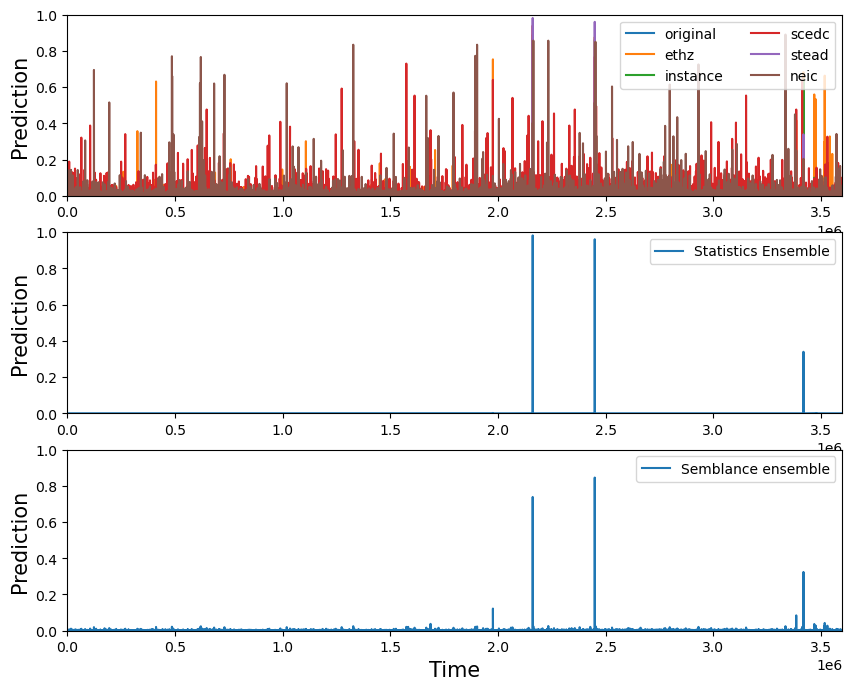

In [29]:
plt.figure(figsize = (10, 8))
plt.subplot(3, 1, 1)
for ipre, pretrain in enumerate(pretrains):
    plt.plot(ensemble_p[ipre, :], label = pretrain)
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(ncols = 2, loc = 'upper right')

plt.subplot(3, 1, 2)
plt.plot(ensemble_statistics(ensemble_p, paras_simple), label = "Statistics Ensemble")
plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(loc = 'upper right')

plt.subplot(3, 1, 3)
plt.plot(ensemble_semblance(ensemble_p, paras_semblance), label = "Semblance ensemble")
plt.xlabel("Time", fontsize = 15); plt.ylabel("Prediction", fontsize = 15); plt.ylim([0, 1]); plt.xlim([0, npts]);
plt.legend(loc = 'upper right')

# EOF